## OR - Assignment 3

##### Author: Joaquim Marset Alsina

### Imports

In [1]:
import os
import numpy as np
from train import *
from inference import *
from data_generator import DataGenerator, DataGeneratorAugmentation
from preprocessing import preprocess_all_video_frames
from utils.segmentation_utils import extract_segmentations
from utils.load_save_utils import load_pickle_dict, save_dict_to_pickle

### Constants

In [2]:
root_path = './'

data_path = os.path.join(root_path, 'cloth3d++_subset')

processed_data_path = os.path.join(root_path, 'processed_data')
images_path = os.path.join(processed_data_path, 'images')
npys_path = os.path.join(processed_data_path, 'npys')

results_path = os.path.join(root_path, 'results')
experiments_path = os.path.join(results_path, 'experiments')
predictions_path = os.path.join(results_path, 'predictions')

segmentations_pickle_path = os.path.join(root_path, 'segmentations.pkl')
pascal_path = os.path.join(root_path, 'VOCtrainval_06-Nov-2007', 'VOCdevkit', 'VOC2007')
seg_objects_path = os.path.join(pascal_path, "SegmentationObject")
seg_classes_path = os.path.join(pascal_path, "SegmentationClass")
pascal_images_path = os.path.join(pascal_path, "JPEGImages")

### Create required folders

In [ ]:
os.makedirs(processed_data_path, exist_ok=True)
os.makedirs(images_path, exist_ok=True)
os.makedirs(npys_path, exist_ok=True)
os.makedirs(results_path, exist_ok=True)
os.makedirs(experiments_path, exist_ok=True)
os.makedirs(predictions_path, exist_ok=True)

### Preprocess the cloth3d++ data

In [ ]:
# This cell takes a lot of time, so execute it once and deactivate it later
# %cd DataReader
# %pwd
# !python extract_frames.py
# %cd ..

# preprocess_all_video_frames(data_path, images_path, npys_path)

# We want to comment something regarding the preprocessing. We were supposed to skip those frames where the subject was cut (i.e. it was partially out of the image)
# However, given that we want to work with square crops (centered in the subject) that should have some extra border, 
# if the square crop (including the border) is outside the image, we also skip that frame.
# Therefore, our total number of frames is almost 34k

### Extract the object segmentations from PascalVOC 2007

In [ ]:
# Here we use this fixed image size given that we later resize it when performing augmentation
image_size = 256

if not os.path.exists(segmentations_pickle_path):
    segmented_objects = extract_segmentations(pascal_images_path, seg_objects_path, seg_classes_path, image_size)
    save_dict_to_pickle(segmentations_pickle_path, segmented_objects)
else:
    segmented_objects = load_pickle_dict(segmentations_pickle_path)

### Load the training and validation split

In [5]:
# We were supposed to extract randomly 4000 images out of the traiing data to act as a validation set. Given that we want
# to perform comparison using different parameters, we decided to fix the validation set

train_names, val_names = load_train_val_split(root_path)

### Experiment 1

In [ ]:
# In this first experiment we want to test the importance of the image size. That is why, together with the next one, we will only change the image
# size, leaving the other parameters as default. We do not apply data augmentation

params_dict = {
    'batch_size' : 32,
    'epochs' : 30,
    'lr' : 2e-4,
    'image_size' : 256,
    'ssim_weight' : 0.85,
    'l1_weight' : 0.1,
    'edge_weight' : 0.9
}

image_size = params_dict['image_size']
batch_size = params_dict['batch_size']

train_gen = DataGenerator(batch_size, images_path, npys_path, train_names, image_size)
validation_gen = DataGenerator(batch_size, images_path, npys_path, val_names, image_size)

train(experiments_path, params_dict, train_gen, validation_gen)

### Experiment 2

In [ ]:
# This second experiment follows the previous one, only changing the image size to 128 instead of 256

params_dict['image_size'] = 128

image_size = params_dict['image_size']

train_gen = DataGenerator(batch_size, images_path, npys_path, train_names, image_size)
validation_gen = DataGenerator(batch_size, images_path, npys_path, val_names, image_size)

train(experiments_path, params_dict, train_gen, validation_gen)

### Experiment 3

In [ ]:
# From the two previous experiments we conclude that having bigger image size is preferred
# For this reason, we want to determine if having bigger batch size can help

params_dict['image_size'] = 256
params_dict['batch_size'] = 64

image_size = params_dict['image_size']
batch_size = params_dict['batch_size']

train_gen = DataGenerator(batch_size, images_path, npys_path, train_names, image_size)
validation_gen = DataGenerator(batch_size, images_path, npys_path, val_names, image_size)

train(experiments_path, params_dict, train_gen, validation_gen)

### Experiment 4

In [ ]:
# In the previous experiment we observe that a bigger batch size did not help, so we return to the original one
# Now, we want to try if using a different learning rate can improve the performance, specially in the last epochs where the
# model saturates and the loss decrease very slowly
# For this reason, we use a higher learning rate applying a exponential decay. Each epoch performs almost 1000 steps with
# a batch size of 32, so we decrease it every 1000 steps with a decay rate of 95%

params_dict['learning_rate'] = 1e-3
params_dict['batch_size'] = 32

batch_size = params_dict['batch_size']

train_gen = DataGenerator(batch_size, images_path, npys_path, train_names, image_size)
validation_gen = DataGenerator(batch_size, images_path, npys_path, val_names, image_size)

train(experiments_path, params_dict, train_gen, validation_gen, lr_decay=True)

### Experiment 5

In [ ]:
# From the previous experiment we conclude that having a higher initial learning rate and applying decay is beneficial
# Therefore, until now the best parameters are: 
# image_size = 256
# batch_size = 32
# learning_rate = 1e-3 with exponential decay

# With those parameters, we move to modify the loss function. We will start by changing the weights of the three original losses
# In this experiment, we want to test if the SSIM should be the one with more weight, as we believe is the most important. For this reason,
# we increase a little bit the weight of this loss, and reduce the weight of the Edge loss

params_dict['ssim_weight'] = 0.9
params_dict['l1_weight'] = 0.1
params_dict['edge_weight'] = 0.4

train_gen = DataGenerator(batch_size, images_path, npys_path, train_names, image_size)
validation_gen = DataGenerator(batch_size, images_path, npys_path, val_names, image_size)

train(experiments_path, params_dict, train_gen, validation_gen, lr_decay=True)

### Experiment 6

In [ ]:
# As we have seen, we were correct about the SSIM loss being more important than the Edge loss, given that with the previous 
# experiment we get the best performance in terms of metrics so far
# Now, we want to test if the L1 loss should have that small weight. Therefore, we will follow the results on the previous experiment, 
# but now increasing the weight of the L1 loss

params_dict['ssim_weight'] = 0.9
params_dict['l1_weight'] = 0.7
params_dict['edge_weight'] = 0.4


train_gen = DataGenerator(batch_size, images_path, npys_path, train_names, image_size)
validation_gen = DataGenerator(batch_size, images_path, npys_path, val_names, image_size)

train(experiments_path, params_dict, train_gen, validation_gen, lr_decay=True)

### Experiment 7

In [ ]:
# Increasing the weight of the L1 loss worsened the overall loss with respect previous experiments. However, the RMSE has not improved at all in the last experiments.
# Before trying to improve the RMSE we are going to perform a last experiment where we invert the weights of the SSIM and Edge loss, given that we have 
# seen that a higher SSIM weight was better

params_dict['ssim_weight'] = 0.4
params_dict['l1_weight'] = 0.1
params_dict['edge_weight'] = 0.9

train_gen = DataGenerator(batch_size, images_path, npys_path, train_names, image_size)
validation_gen = DataGenerator(batch_size, images_path, npys_path, val_names, image_size)

train(experiments_path, params_dict, train_gen, validation_gen, lr_decay=True)

### Experiment 8

In [ ]:
# It is curious that in the previous experiment the loss decreased and was the lowest in all the experiments so far, but we have
# to consider it already started very low. Therefore, it is because the small weight on the SSIM loss, that makes it smaller overall

# Now, we are going to modify the loss that is used to train the weights via gradient descent. We will include the RMSE in the GradientTape computation,
# weighting the original combined loss by 0.5, and the RMSE also by 0.5

params_dict['ssim_weight'] = 0.9
params_dict['l1_weight'] = 0.1
params_dict['edge_weight'] = 0.4


train_gen = DataGenerator(batch_size, images_path, npys_path, train_names, image_size)
validation_gen = DataGenerator(batch_size, images_path, npys_path, val_names, image_size)

train(experiments_path, params_dict, train_gen, validation_gen, lr_decay=True, modified_loss=ModifiedLossMode.EqualWeights)

### Experiment 9

In [ ]:
# We have seen an improvement in the RMSE, so we are going to perform a final experiment to change the loss.
# We are going to assume unequal weights of the last weighted sum (i.e. 0.7 for the RMSE and 0.3 for the original loss)
# And we are going to remove the L1 loss given the small importance it seems to have

params_dict['ssim_weight'] = 0.9
params_dict['l1_weight'] = 0
params_dict['edge_weight'] = 0.4


train_gen = DataGenerator(batch_size, images_path, npys_path, train_names, image_size)
validation_gen = DataGenerator(batch_size, images_path, npys_path, val_names, image_size)

train(experiments_path, params_dict, train_gen, validation_gen, lr_decay=True, modified_loss=ModifiedLossMode.UnequalWeights)

### Experiment 10

In [ ]:
# We observe similar results as the eighth experiment, but we believe it could improve if we run it for more epochs.
# Therefore, we are going to consider the ninth experiment as our best one, and perform data augmentation like we did in the first assignment
# We are going to augment an image with probability of 50%, adding 1 or 2 objects.
# The idea is see if the model is able to correctly predict depths with the overlapping and occlusion the objects produce

train_gen = DataGeneratorAugmentation(batch_size, images_path, npys_path, train_names, image_size, segmented_objects)
validation_gen = DataGenerator(batch_size, images_path, npys_path, val_names, image_size)

train(experiments_path, params_dict, train_gen, validation_gen, lr_decay=True, modified_loss=ModifiedLossMode.UnequalWeights)

### Final Experiment

In [ ]:
# Run experiment 9 (the best configuration) with 50 epochs to provide the final quantitative and qualitative results
# The folder will have the same format 'experiment_i'. Manually rename it as 'final_experiment'

params_dict['epochs'] = 50

train_gen = DataGenerator(batch_size, images_path, npys_path, train_names, image_size)
validation_gen = DataGenerator(batch_size, images_path, npys_path, val_names, image_size)

train(experiments_path, params_dict, train_gen, validation_gen, lr_decay=True, modified_loss=ModifiedLossMode.UnequalWeights)

### Compute validation metrics for all the experiments

In [ ]:
plot_experiments_val_metric(experiments_path, results_path, 'val_loss')
plot_experiments_val_metric(experiments_path, results_path, 'val_rmse')
plot_experiments_val_metric(experiments_path, results_path, 'val_acc_1.25')
plot_experiments_val_metric(experiments_path, results_path, 'val_acc_2_1.25')

In [3]:
# Plot metrics of the best model

best_experiment_path = os.path.join(experiments_path, 'final_experiment')

plot_best_experiment_val_metrics(best_experiment_path, results_path)

### Perform inference with the best model

In [6]:
weights_path = os.path.join(experiments_path, 'final_experiment')
image_size = 256

perform_inference(weights_path, images_path, npys_path, val_names, image_size, predictions_path)

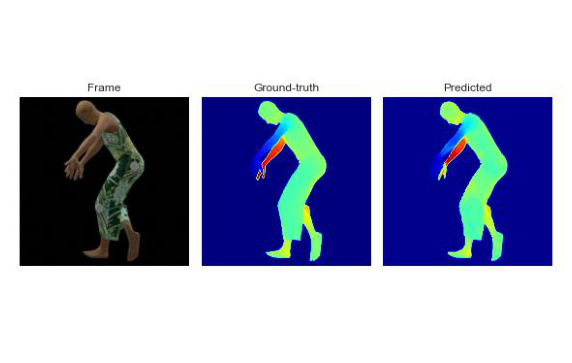

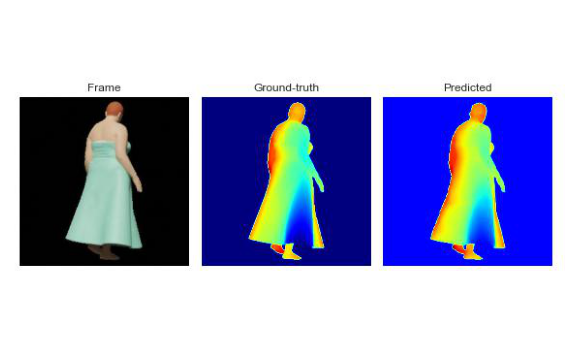

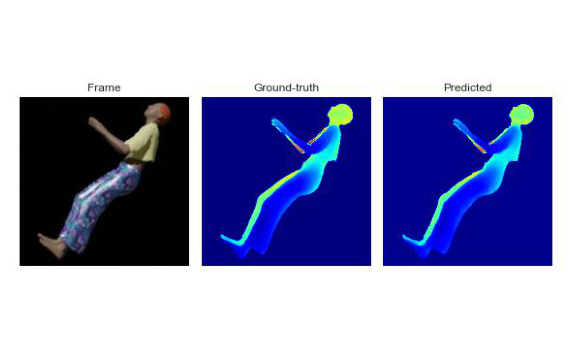

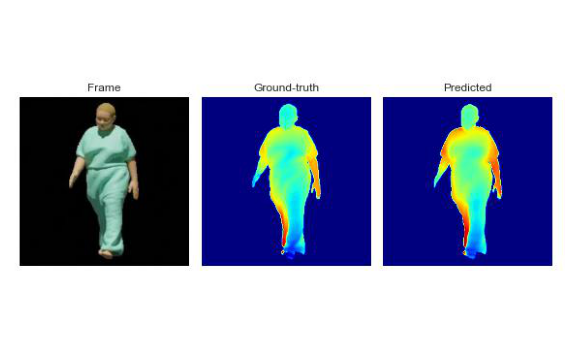

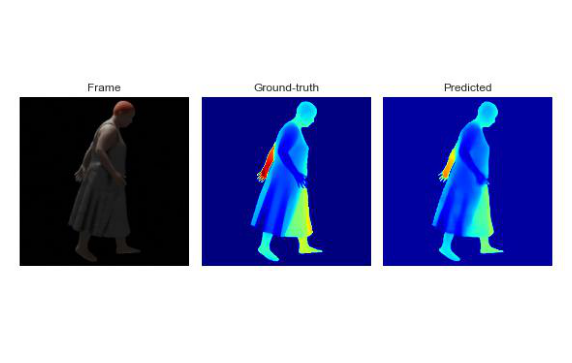

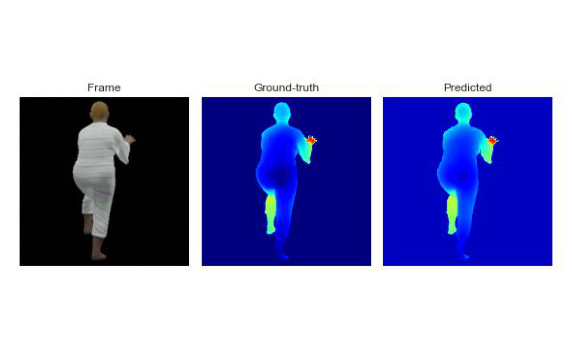

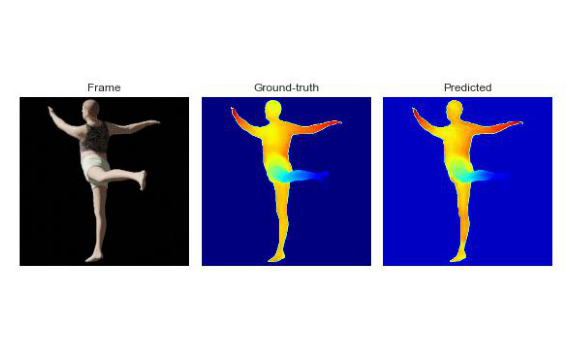

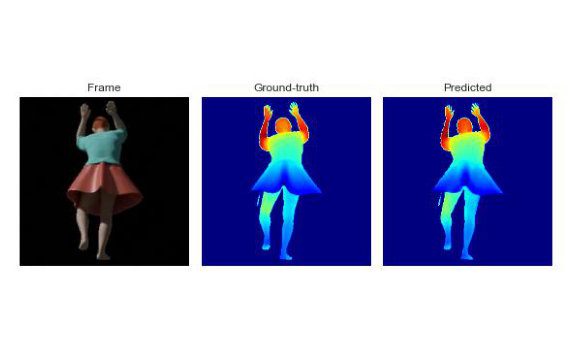

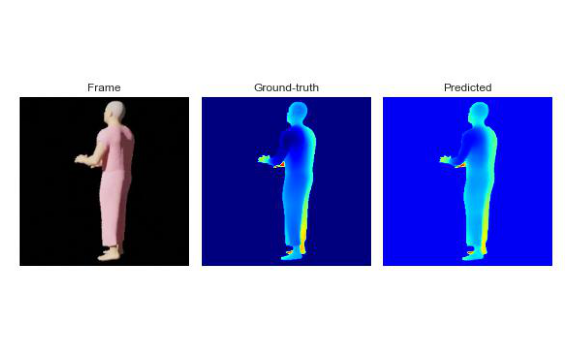

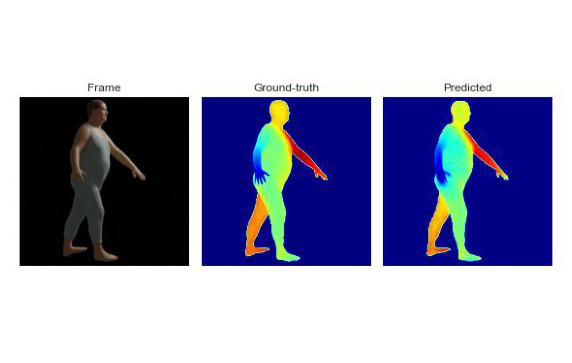

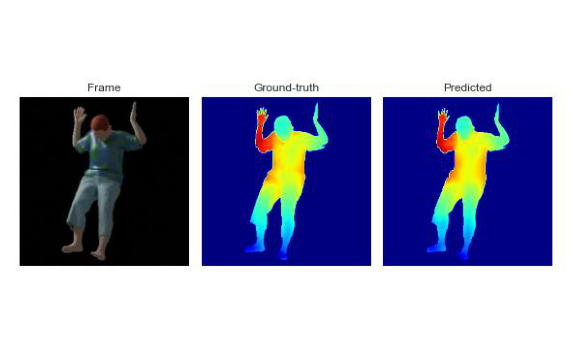

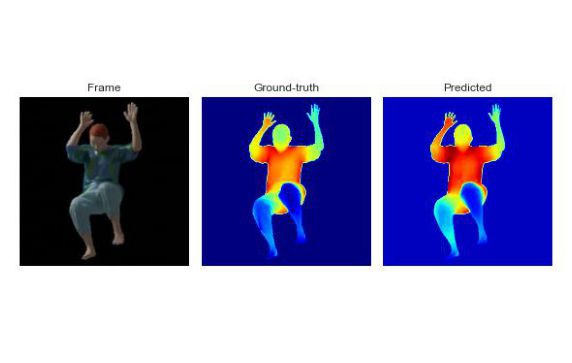

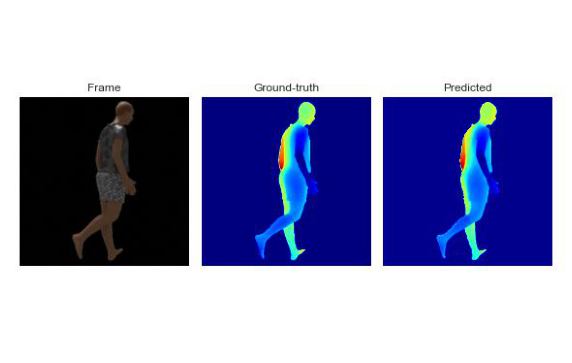

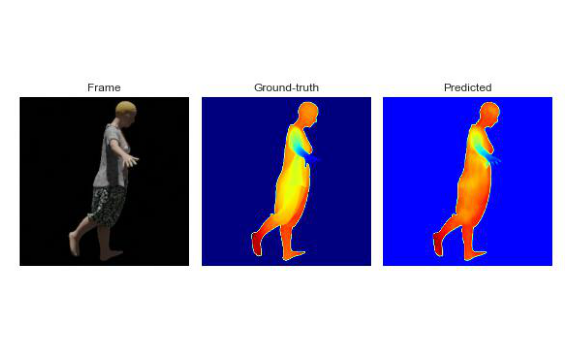

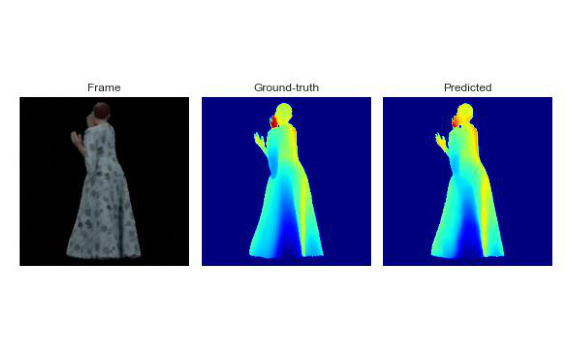

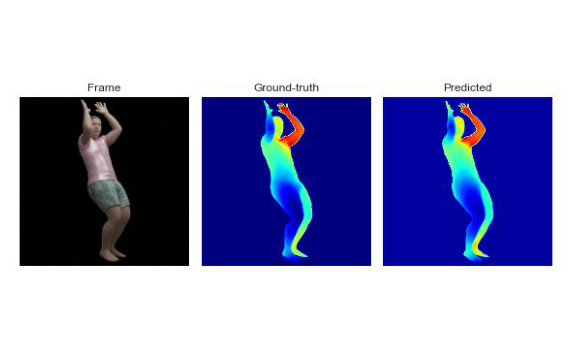

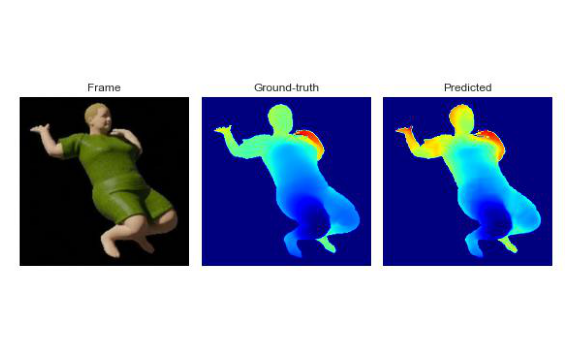

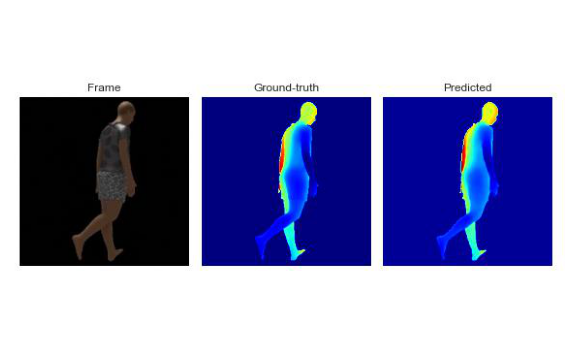

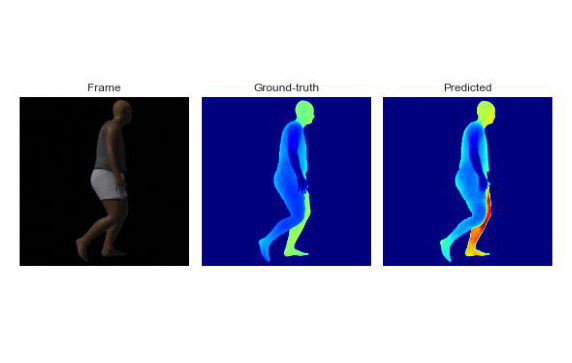

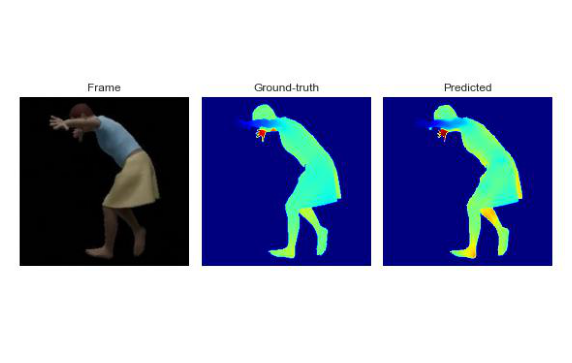

In [7]:
# Display some results

predictions = os.listdir(predictions_path)
num_test_images = len(predictions)
num_to_show = 20
indices = np.random.choice(num_test_images, num_to_show)

for index in indices:
    path = os.path.join(predictions_path, predictions[index])
    image = plt.imread(path)
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(image)